In [2]:
import pandas as pd
from scipy.interpolate import interp1d
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter
import seaborn as sns


In [1]:
# Load the CSV file into a Pandas DataFrame
df = pd.read_csv('./Churn-Data.csv')
df.head()


,cID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,TV_Streaming,Movie_Streaming,Contract,PaperlessBilling,Method_Payment,Charges_Month,TotalCharges,Churn
0,4223-BKEOR,Female,0,No,Yes,21,Yes,No,DSL,Yes,...,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8,No
1,6035-RIIOM,Female,0,No,No,54,Yes,Yes,Fiber optic,No,...,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45,No
2,3797-VTIDR,Male,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45,Yes
3,2568-BRGYX,Male,0,No,No,4,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95,Yes
4,2775-SEFEE,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,...,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,,No


In [4]:
df.isnull().sum()

cID                 0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
TV_Streaming        0
Movie_Streaming     0
Contract            0
PaperlessBilling    0
Method_Payment      0
Charges_Month       0
TotalCharges        0
Churn               0
dtype: int64

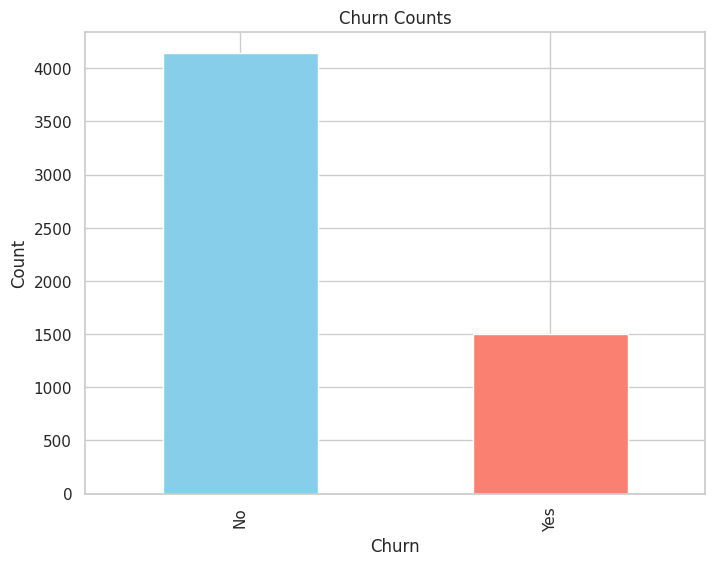

In [5]:
churn_counts = df['Churn'].value_counts()

plt.figure(figsize=(8, 6))  # Optional: adjust figure size

# Use seaborn style (optional)
sns.set(style="whitegrid")

# Plotting the bar graph
churn_counts.plot(kind='bar', color=['skyblue', 'salmon'])

# Adding titles and labels
plt.title('Churn Counts')
plt.xlabel('Churn')
plt.ylabel('Count')

# Display the plot
plt.show()

In [6]:
# Separate the target variable (Churn) from the other features
Y = df['Churn']
X = df.drop('Churn', axis=1)

In [7]:
X.drop('cID',axis=1,inplace=True)
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,TV_Streaming,Movie_Streaming,Contract,PaperlessBilling,Method_Payment,Charges_Month,TotalCharges
0,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.8
1,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
2,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
3,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
4,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,


In [8]:
# Convert 'TotalCharges' to float
X['TotalCharges'] = X['TotalCharges'].replace(' ', '0')
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,TV_Streaming,Movie_Streaming,Contract,PaperlessBilling,Method_Payment,Charges_Month,TotalCharges
0,Female,0,No,Yes,21,Yes,No,DSL,Yes,No,Yes,No,No,Yes,One year,No,Mailed check,64.85,1336.80
1,Female,0,No,No,54,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),97.20,5129.45
2,Male,0,Yes,No,1,No,No phone service,DSL,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,23.45,23.45
3,Male,0,No,No,4,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.20,237.95
4,Male,0,No,Yes,0,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),61.90,0.00


In [9]:
from sklearn.preprocessing import StandardScaler, LabelEncoder
# Converting 'TotalCharges' to numeric
X['TotalCharges'] = pd.to_numeric(X['TotalCharges'], errors='coerce')

# Perform spline interpolation for missing values
mask = X['TotalCharges'].isna()
indices = X.index[mask]
interpolator = interp1d(X.index[~mask], X.loc[~mask, 'TotalCharges'], kind='quadratic', fill_value='extrapolate')
X.loc[mask, 'TotalCharges'] = interpolator(indices)

# Scale numerical columns ('tenure', 'Charges_Month', 'TotalCharges')
scaler = StandardScaler()
X[['tenure', 'Charges_Month', 'TotalCharges']] = scaler.fit_transform(X[['tenure', 'Charges_Month', 'TotalCharges']])

# Encode target variable Y using label encoder
le = LabelEncoder()
Y_encoded = le.fit_transform(Y)

# Encode categorical columns in X using label encoder
categorical_columns = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService',
                       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'TV_Streaming',
                       'Movie_Streaming', 'Contract', 'PaperlessBilling', 'Method_Payment']

for col in categorical_columns:
    X[col] = le.fit_transform(X[col])

print()

In [10]:
X.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,TV_Streaming,Movie_Streaming,Contract,PaperlessBilling,Method_Payment,Charges_Month,TotalCharges
0,0,0,0,1,-0.465683,1,0,0,2,0,2,0,0,2,1,0,3,-0.000474,-0.419925
1,0,0,0,0,0.885537,1,2,1,0,2,0,0,2,2,2,1,0,1.074754,1.256017
2,1,0,1,0,-1.284605,0,1,0,0,0,0,0,0,0,0,1,2,-1.376499,-1.000283
3,1,0,0,0,-1.161766,1,0,1,0,0,0,0,0,0,0,1,2,0.177346,-0.905497
4,1,0,0,1,-1.325551,1,2,0,2,2,0,2,0,0,2,1,0,-0.098524,-1.010646


In [11]:
Y_encoded

array([0, 0, 1, ..., 0, 1, 0])

In [12]:
# Apply SMOTE for oversampling
smote = SMOTE(random_state=42)
X_resampled, Y_resampled = smote.fit_resample(X, Y_encoded)

# verifying class distribution
print("Before SMOTE:", Counter(Y))
print("After SMOTE:", Counter(Y_resampled))


Before SMOTE: Counter({'No': 4138, 'Yes': 1496})
After SMOTE: Counter({0: 4138, 1: 4138})


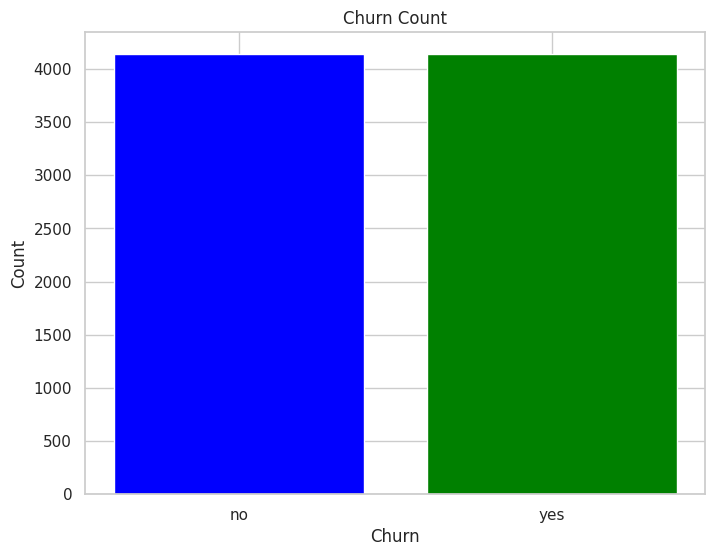

In [13]:
# Creating the DataFrame
resampled_data = pd.DataFrame(X_resampled)
resampled_data['target'] = Y_resampled

value_counts = resampled_data['target'].value_counts()

# Plotting the bar graph
plt.figure(figsize=(8, 6))
plt.bar(value_counts.index.map({0: 'no', 1: 'yes'}), value_counts.values, color=['blue', 'green'])
plt.title('Churn Count')
plt.xlabel('Churn')
plt.ylabel('Count')
plt.show()

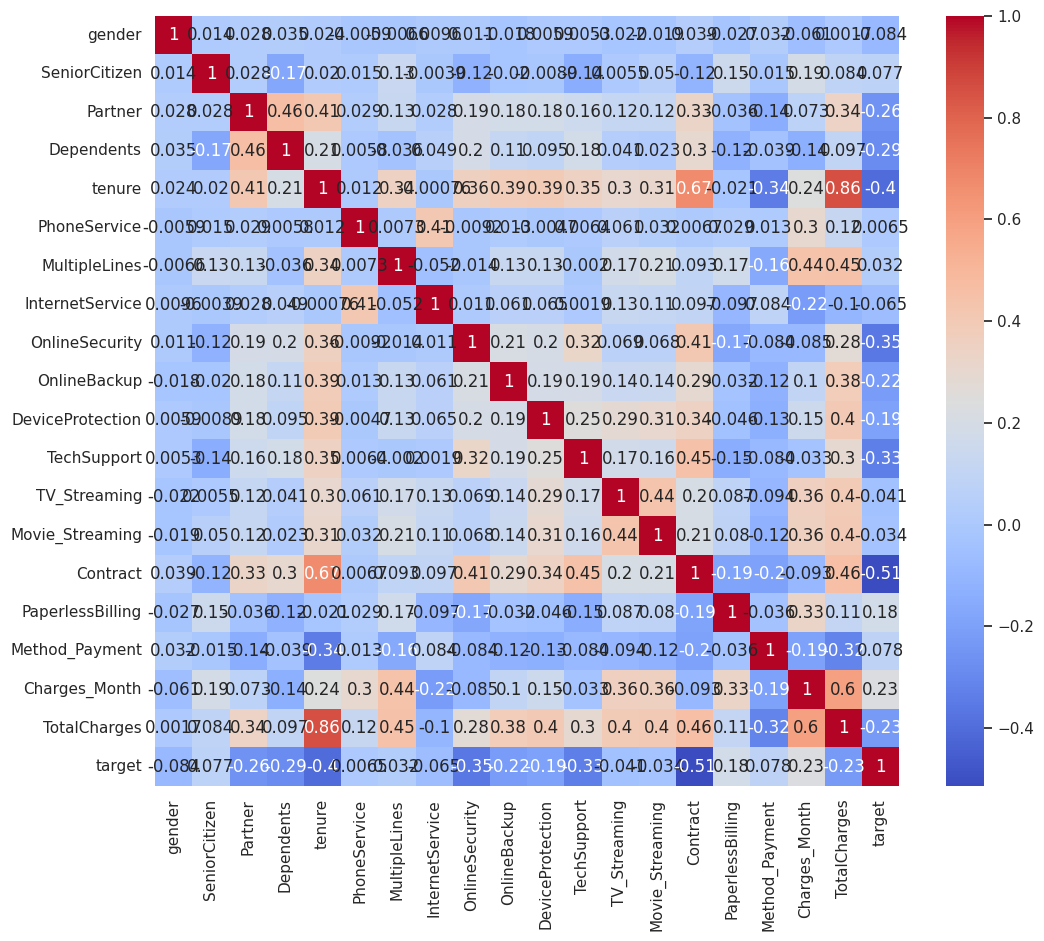

target              1.000000
Charges_Month       0.227268
PaperlessBilling    0.182675
Method_Payment      0.077659
SeniorCitizen       0.077185
MultipleLines       0.031791
PhoneService        0.006513
Movie_Streaming    -0.033687
TV_Streaming       -0.041403
InternetService    -0.065294
gender             -0.084456
DeviceProtection   -0.194435
OnlineBackup       -0.223141
TotalCharges       -0.225047
Partner            -0.258931
Dependents         -0.286675
TechSupport        -0.330928
OnlineSecurity     -0.354882
tenure             -0.403494
Contract           -0.513659
Name: target, dtype: float64


In [14]:
# Compute correlation matrix
correlation_matrix = resampled_data.corr()

# Plotting the heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

# Get correlation of each feature with the target variable
corr_with_target = correlation_matrix['target'].sort_values(ascending=False)
print(corr_with_target)

In [15]:
columns_to_drop = [
    'gender',
    'Movie_Streaming',
    'TV_Streaming',
    'InternetService',
]
# Drop columns from resampled_data
resampled_data.drop(columns=columns_to_drop, inplace=True)
resampled_data.info()

X_data = resampled_data.drop(columns=['target'])
Y_data = resampled_data['target']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8276 entries, 0 to 8275
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   SeniorCitizen     8276 non-null   int64  
 1   Partner           8276 non-null   int64  
 2   Dependents        8276 non-null   int64  
 3   tenure            8276 non-null   float64
 4   PhoneService      8276 non-null   int64  
 5   MultipleLines     8276 non-null   int64  
 6   OnlineSecurity    8276 non-null   int64  
 7   OnlineBackup      8276 non-null   int64  
 8   DeviceProtection  8276 non-null   int64  
 9   TechSupport       8276 non-null   int64  
 10  Contract          8276 non-null   int64  
 11  PaperlessBilling  8276 non-null   int64  
 12  Method_Payment    8276 non-null   int64  
 13  Charges_Month     8276 non-null   float64
 14  TotalCharges      8276 non-null   float64
 15  target            8276 non-null   int64  
dtypes: float64(3), int64(13)
memory usage: 1.0

In [16]:

# Split data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(X_data, Y_data, test_size=0.2, random_state=42)

# Initialize variables to track the best model and its scores
best_model = None
best_model_name = ""
best_accuracy = 0
best_f1 = 0

# Initialize classifiers
classifiers = {
    'Logistic Regression': LogisticRegression(),
    'Random Forest': RandomForestClassifier(),
    'Gradient Boosting': GradientBoostingClassifier(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'XGBoost': XGBClassifier()
}

# Train and evaluate models
for clf_name, clf in classifiers.items():
    clf.fit(X_train, Y_train)
    Y_pred = clf.predict(X_test)

    accuracy = accuracy_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred, average='weighted')  # Use weighted average for multiclass problems

    print(f"{clf_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print()

    # Check if current model is the best so far
    if accuracy > best_accuracy and f1 > best_f1:
        best_accuracy = accuracy
        best_f1 = f1
        best_model = clf
        best_model_name = clf_name


Logistic Regression:
  Accuracy: 0.7693
  F1-score: 0.7687

Random Forest:
  Accuracy: 0.8279
  F1-score: 0.8278

Gradient Boosting:
  Accuracy: 0.8025
  F1-score: 0.8022

SVM:
  Accuracy: 0.7862
  F1-score: 0.7857

K-Nearest Neighbors:
  Accuracy: 0.7856
  F1-score: 0.7840

Decision Tree:
  Accuracy: 0.7693
  F1-score: 0.7693

XGBoost:
  Accuracy: 0.8249
  F1-score: 0.8248



In [17]:
print(f"Best model: {best_model_name}")
print(f"  Best Accuracy: {best_accuracy:.4f}")
print(f"  Best F1-score: {best_f1:.4f}")


Best model: Random Forest
  Best Accuracy: 0.8279
  Best F1-score: 0.8278


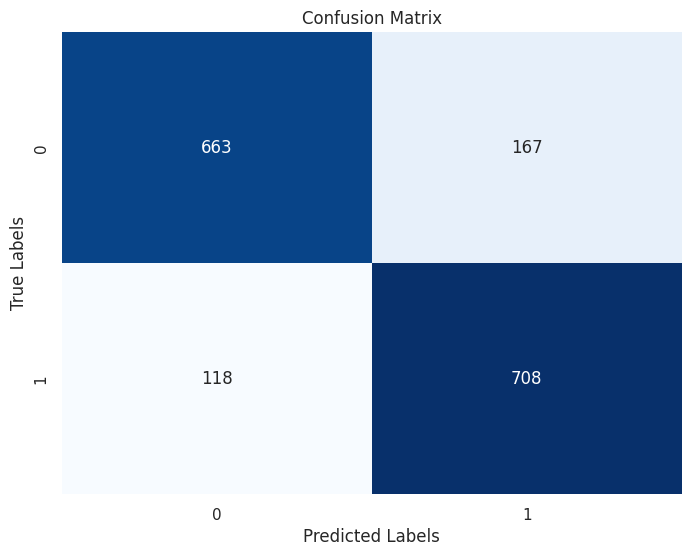

In [18]:
# Generate confusion matrix for the best model
Y_pred_best = best_model.predict(X_test)
conf_matrix = confusion_matrix(Y_test, Y_pred_best)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=best_model.classes_, yticklabels=best_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()